In [2]:
import numpy as np
import pandas as pd
import time

# Tensorflow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Logging/Warnings
import warnings
warnings.filterwarnings('ignore')
tf.autograph.set_verbosity(0)

# Load data
submission = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

features = [x for x in train.columns if x != 'label']

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
y = train["label"]
X = train.drop("label",axis=1)
X_test = test

Train Shape: (42000, 785)
Test Shape: (28000, 784)


In [3]:
from sklearn.model_selection import train_test_split
INPUT_SIZE = (28,28,1)
NUM_CLASSES = 10
scaler = MinMaxScaler()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=41)
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(test)   
# Convert training examples to shape (28,28,1)
X_train = np.reshape(X_train, (X_train.shape[0], *INPUT_SIZE))
X_valid = np.reshape(X_valid, (X_valid.shape[0], *INPUT_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], *INPUT_SIZE))
        
# Convert target vectors for keras input
Y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
Y_valid = keras.utils.to_categorical(y_valid, NUM_CLASSES)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

inp = keras.Input(shape = INPUT_SIZE)
x = layers.Conv2D(16, 4,strides=2, padding="same", activation="relu")(inp)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, 3,strides=1, padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, 5,strides=1, padding="same", activation="relu")(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
out = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inp, out, name="model")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 16)        272       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          51264     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0     

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
inp = keras.Input(shape = INPUT_SIZE)
model = keras.Sequential()
model.add(inp)
model.add(Conv2D(16, 4,strides=2, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, 3,strides=1, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, 5,strides=1, padding="same", activation="relu"))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(10, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 16)        272       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          51264     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

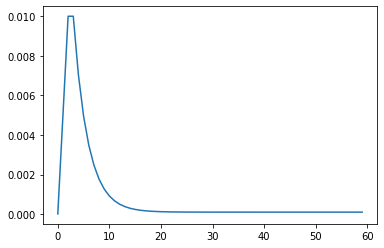

In [8]:
def get_lr_callback(epoch,lr):
    lr_start   = 0.00001
    lr_max     = 0.01#0.00000125 * 1 * batch_size
    lr_min     = 0.0001
    lr_ramp_ep = 2
    lr_sus_ep  = 1
    lr_decay   = 0.7
    
    def lrfn(epoch):
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr
    
    return lrfn(epoch)

lr_callback = tf.keras.callbacks.LearningRateScheduler(get_lr_callback, verbose=True)
x = [x for x in range(60)]
plt.plot(x,[get_lr_callback(x,.1) for x in x])
plt.show()

In [9]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                optimizer = tf.keras.optimizers.Adam(), 
                metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [10]:
history = model.fit(X_train, Y_train,validation_data = (X_valid, Y_valid),batch_size = 64,epochs = 20,callbacks=[lr_callback])

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
525/525 [==============================] - 5s 5ms/step - loss: 2.2539 - categorical_accuracy: 0.2200 - val_loss: 2.1724 - val_categorical_accuracy: 0.3211
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.005005.
525/525 [==============================] - 2s 4ms/step - loss: 0.2497 - categorical_accuracy: 0.9234 - val_loss: 0.1066 - val_categorical_accuracy: 0.9708
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.01.
525/525 [==============================] - 2s 4ms/step - loss: 0.1603 - categorical_accuracy: 0.9569 - val_loss: 0.1801 - val_categorical_accuracy: 0.9611
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.01.
525/525 [==============================] - 2s 5ms/step - loss: 0.1268 - categorical_accuracy: 0.9671 - val_loss: 0.1604 - val_categorical_accuracy: 0.9662
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning

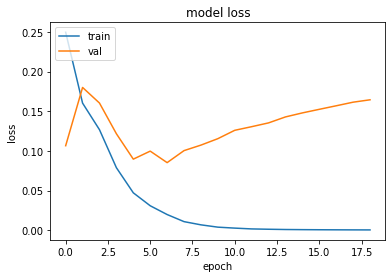

In [11]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
                            rotation_range=10,
                            zoom_range = 0.2, 
                            width_shift_range=0.1, 
                            height_shift_range=0.1)
                        

datagen.fit(X_train)

In [19]:
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
model = keras.Sequential()
inp = keras.Input(shape = INPUT_SIZE)


model.add(inp)
model.add(Conv2D(16, 4,strides=2, padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(.3)) # adding dropout 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, 3,strides=1, padding="same", activation="relu"))
model.add(Dropout(.3)) # adding dropout 
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, 5,strides=1, padding="same", activation="relu"))
model.add(layers.Dropout(.3)) # adding dropout 
model.add(layers.BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(10, activation="softmax"))


model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 14, 14, 16)        272       
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 32)         

In [20]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, verbose=1,
    mode='auto', restore_best_weights=True
)

In [21]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                optimizer = tf.keras.optimizers.Adam(), 
                metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [22]:
hist1 = model.fit(datagen.flow(X_train, Y_train,batch_size=64),validation_data = (X_valid, Y_valid),batch_size = 64,epochs = 20,callbacks=[lr_callback,earlystop])


Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
525/525 [==============================] - 6s 10ms/step - loss: 2.4426 - categorical_accuracy: 0.1326 - val_loss: 2.1972 - val_categorical_accuracy: 0.1602
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.005005.
525/525 [==============================] - 5s 10ms/step - loss: 0.4632 - categorical_accuracy: 0.8521 - val_loss: 0.1553 - val_categorical_accuracy: 0.9624
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.01.
525/525 [==============================] - 5s 10ms/step - loss: 0.3042 - categorical_accuracy: 0.9079 - val_loss: 0.3448 - val_categorical_accuracy: 0.8945
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.01.
525/525 [==============================] - 6s 11ms/step - loss: 0.2416 - categorical_accuracy: 0.9281 - val_loss: 0.1198 - val_categorical_accuracy: 0.9726
Epoch 5/20

Epoch 00005: LearningRateScheduler setting lear

In [23]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                optimizer = tf.keras.optimizers.SGD(), # optimize with SGD
                metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [24]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.0001,verbose=1)

In [26]:
hist2 = model.fit(datagen.flow(X_train, Y_train,batch_size=64),validation_data = (X_valid, Y_valid),batch_size = 128,epochs = 60,callbacks=[earlystop,reduce_lr])

Epoch 1/60
525/525 [==============================] - 5s 10ms/step - loss: 0.0810 - categorical_accuracy: 0.9746 - val_loss: 0.0414 - val_categorical_accuracy: 0.9883
Epoch 2/60
525/525 [==============================] - 5s 9ms/step - loss: 0.0804 - categorical_accuracy: 0.9740 - val_loss: 0.0416 - val_categorical_accuracy: 0.9885
Epoch 3/60
525/525 [==============================] - 5s 9ms/step - loss: 0.0783 - categorical_accuracy: 0.9748 - val_loss: 0.0415 - val_categorical_accuracy: 0.9885
Epoch 4/60
525/525 [==============================] - 5s 10ms/step - loss: 0.0773 - categorical_accuracy: 0.9753 - val_loss: 0.0415 - val_categorical_accuracy: 0.9885

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Epoch 5/60
525/525 [==============================] - 5s 9ms/step - loss: 0.0794 - categorical_accuracy: 0.9747 - val_loss: 0.0416 - val_categorical_accuracy: 0.9885
Epoch 6/60
525/525 [==============================] - 5s 10ms/step - loss: 0.0769 - ca

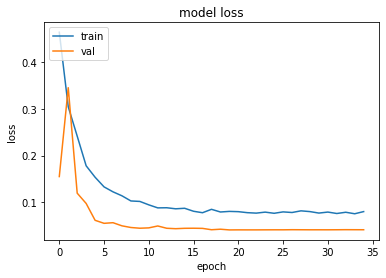

In [27]:
plt.plot(hist1.history['loss'][1:]+hist2.history['loss'])
plt.plot(hist1.history['val_loss'][1:]+hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
model = keras.Sequential()
inp = keras.Input(shape = INPUT_SIZE)


model.add(inp)
model.add(Conv2D(64, 4,strides=2, padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(.2)) # adding dropout 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, 5,strides=2, padding="same", activation="relu"))
model.add(Dropout(.2)) # adding dropout 
model.add(BatchNormalization())
model.add(Conv2D(32, 4,strides=2, padding="same", activation="relu"))

model.add(layers.Dropout(.2)) # adding dropout 
model.add(layers.BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(10, activation="softmax"))


model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 14, 14, 64)        1088      
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 32)          51232     
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 32)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 4, 4, 32)         

In [29]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                optimizer = tf.keras.optimizers.Adam(), 
                metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [30]:
hist1 = model.fit(datagen.flow(X_train, Y_train,batch_size=64),validation_data = (X_valid, Y_valid),epochs = 20,callbacks=[lr_callback,earlystop])

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
525/525 [==============================] - 7s 12ms/step - loss: 2.1629 - categorical_accuracy: 0.2399 - val_loss: 1.9801 - val_categorical_accuracy: 0.4031
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.005005.
525/525 [==============================] - 6s 11ms/step - loss: 0.4473 - categorical_accuracy: 0.8584 - val_loss: 0.1566 - val_categorical_accuracy: 0.9536
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.01.
525/525 [==============================] - 6s 11ms/step - loss: 0.2986 - categorical_accuracy: 0.9122 - val_loss: 0.1046 - val_categorical_accuracy: 0.9702
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.01.
525/525 [==============================] - 6s 11ms/step - loss: 0.2288 - categorical_accuracy: 0.9321 - val_loss: 0.1912 - val_categorical_accuracy: 0.9510
Epoch 5/20

Epoch 00005: LearningRateScheduler setting lear

In [31]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                optimizer = tf.keras.optimizers.SGD(), # optimize with SGD
                metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [32]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.0001,verbose=1)

In [33]:
hist2 = model.fit(datagen.flow(X_train, Y_train,batch_size=128),validation_data = (X_valid, Y_valid),batch_size = 128,epochs = 40,callbacks=[earlystop,reduce_lr])

Epoch 1/40
263/263 [==============================] - 5s 19ms/step - loss: 0.0657 - categorical_accuracy: 0.9789 - val_loss: 0.0349 - val_categorical_accuracy: 0.9900
Epoch 2/40
263/263 [==============================] - 5s 18ms/step - loss: 0.0691 - categorical_accuracy: 0.9784 - val_loss: 0.0350 - val_categorical_accuracy: 0.9898
Epoch 3/40
263/263 [==============================] - 5s 18ms/step - loss: 0.0671 - categorical_accuracy: 0.9791 - val_loss: 0.0350 - val_categorical_accuracy: 0.9896
Epoch 4/40
263/263 [==============================] - 5s 19ms/step - loss: 0.0707 - categorical_accuracy: 0.9773 - val_loss: 0.0345 - val_categorical_accuracy: 0.9901
Epoch 5/40
263/263 [==============================] - 5s 18ms/step - loss: 0.0708 - categorical_accuracy: 0.9780 - val_loss: 0.0347 - val_categorical_accuracy: 0.9902
Epoch 6/40
263/263 [==============================] - 5s 19ms/step - loss: 0.0711 - categorical_accuracy: 0.9780 - val_loss: 0.0344 - val_categorical_accuracy: 0.990

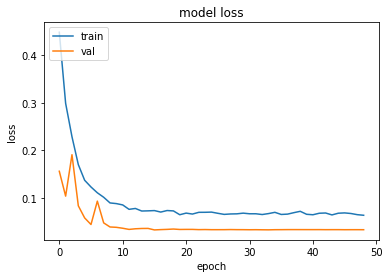

In [34]:
plt.plot(hist1.history['loss'][1:]+hist2.history['loss'])
plt.plot(hist1.history['val_loss'][1:]+hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [35]:
def viz_num(num):
    #Reshape the 768 values to a 28x28 image
    image = X_valid[num].reshape([28,28])
    plt.title('Sample: %d  Label: %d , pred : %d' % (num, y_valid.iloc[num],model.predict(X_valid)[num].argmax()))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

In [36]:
pred = model.predict(X_valid).argmax(axis=1)
dis_match = list(y_valid-pred)
num1 = np.argmin(dis_match)
dis_match = dis_match[:num1]
num2 = np.argmin(dis_match)
dis_match = dis_match[:num2]
num3 = np.argmin(dis_match)

ValueError: attempt to get argmin of an empty sequence

In [37]:
viz_num(num3)

NameError: name 'num3' is not defined

In [38]:
submission['Label'] = model.predict(X_test).argmax(axis=-1)
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [39]:
submission.to_csv('submission1.csv', index=False)